In [2]:
#!pip install --upgrade pandas

In [3]:
#!pip install pyarrow

In [4]:
import pandas as pd
import numpy as np
from numpy import nan as NA
import os
import gc
from pandas.tseries.offsets import MonthEnd

from azure.storage.blob import BlockBlobService
import pyarrow.parquet as pq
from io import StringIO
from io import BytesIO

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
%matplotlib inline

In [6]:
#Azure account credentials
azure_storage_account_name = "agedatasciencecocstorage"
azure_storage_account_key = "V/FXG+lIWtYc854wbRA8BxGCLGJijS0NDwLvNHfmAxqRopAL3WHWGIQoHxpArG9lZoX+iY+dvtPYoB379w4MIw=="

if azure_storage_account_name is None or azure_storage_account_key is None:
    raise Exception("You must provide a name and key for an Azure Storage account")

In [7]:
# First, we need to connect to our blob via the BlobService
blob_service = BlockBlobService(azure_storage_account_name, azure_storage_account_key)
# There are also methods to list containers and blobs
#containers = blob_service.list_containers()
blobs = blob_service.list_blobs('banking-dm')

In [8]:
# # List the blobs in the container.
# print("\nList blobs in the container")
# #generator = block_blob_service.list_blobs(container_name)
# for blob in blobs:
#     print("\t Blob name: " + blob.name)

### Read Data

In [9]:
container_name = "banking-dm"

In [10]:
blob_name_parquet = 'ailiev/3M_AVG_MCIF_2018-01__2018-03.parquet.gzip'
byte_stream = BytesIO()
try:
    blob_service.get_blob_to_stream(container_name=container_name, blob_name=blob_name_parquet, stream=byte_stream)
    df = pq.read_table(source=byte_stream).to_pandas()
    # Do work on df ...
finally:
    # Add finally block to ensure closure of the stream
    byte_stream.close()

In [11]:
df.shape

(100215, 278)

In [12]:
pd.value_counts(df['CUSTOMER_TYPE'])

Individual        84302
Small Business    15410
Professional        503
Name: CUSTOMER_TYPE, dtype: int64

In [13]:
#remove SBBs
df = df[df['CUSTOMER_TYPE']=="Individual"]

In [14]:
df.shape

(84302, 278)

### Analysis

In [15]:
del df['AVG_PERIOD']

In [16]:
demographic_columns = ['Customer_ID', 'CUSTOMER_TYPE', 'CUSTOMER_CATEGORY', 'GENDER', 'MARITAL_STATUS', 'CUSTOMER_ECO_BRANCH', 'SECTOR', 'AGE_MONTHS']

In [17]:
columns_for_pca = [col for col in df.columns if col not in demographic_columns]

In [18]:
len(columns_for_pca)

269

In [19]:
df_scaled = df[columns_for_pca]

In [20]:
df_scaled.shape

(84302, 269)

In [21]:
#replaces inf with nan
# df_scaled.replace([np.inf, -np.inf], np.nan)
df_scaled.replace( -np.inf, np.nan, inplace=True)

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [22]:
#df_scaled.iloc[:, 179:182].head(10)

In [23]:
df_scaled.fillna(0, inplace=True)

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [24]:
# Standardize the feature matrix
X = StandardScaler().fit_transform(df_scaled)

In [25]:
df_stscaler = StandardScaler().fit_transform(X)

In [26]:
pca = PCA(.85, random_state=12345)

In [27]:
pca.fit(df_stscaler)

PCA(copy=True, iterated_power='auto', n_components=0.85, random_state=12345,
  svd_solver='auto', tol=0.0, whiten=False)

In [28]:
pca.n_components_

33

In [29]:
pca.n_features_

269

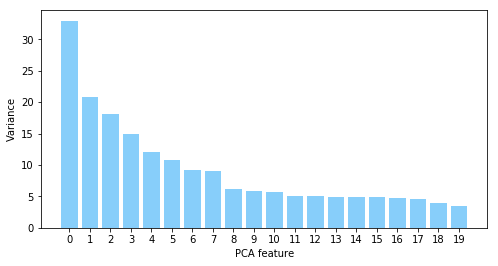

In [30]:
features = range(pca.n_components_)

plt.figure(figsize=(8,4))
plt.bar(features[:20], pca.explained_variance_[:20], color='lightskyblue')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features[:20])
plt.show()

In [31]:
pca.explained_variance_ratio_.sum()

0.8504236674580355

In [32]:
principalComponents = pca.fit_transform(df_stscaler)

In [33]:
principalComponents.shape

(84302, 33)

In [ ]:
# # Euclidean Distance Caculator
# def dist(a, b, ax=1):
#     return np.linalg.norm(a - b, axis=ax)

In [34]:
j = 0
acc_table = pd.DataFrame(columns = ['Clusters', 'Cost'])
y = []
for i in np.arange(2, 21):
    y.append('Clusters ' + str(i))
acc_table['Clusters'] = y
for k in range (2, 21):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    kmeans_model = KMeans(n_clusters=k, random_state=12345).fit(principalComponents)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    #labels_model = kmeans_model.labels_

    # Sum of distances of samples to their closest cluster center
    interia = kmeans_model.inertia_
    #print("Clusters:",k, " Cost:", interia)
    acc_table.iloc[j,1] = interia
    j += 1

In [35]:
acc_table['Diff'] = abs(acc_table['Cost'].diff())

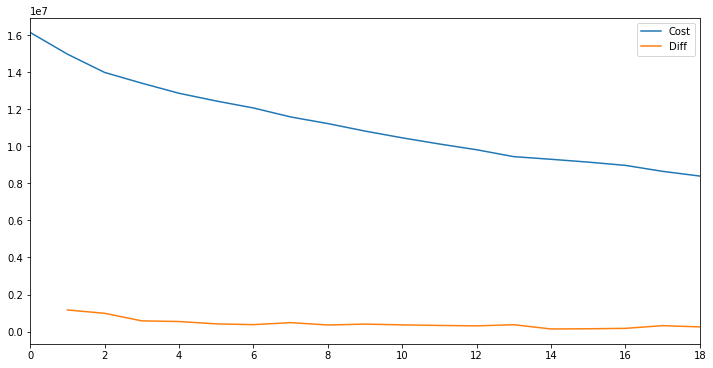

In [36]:
plt.rcParams["figure.figsize"] = (12,6)
acc_table.plot.line()

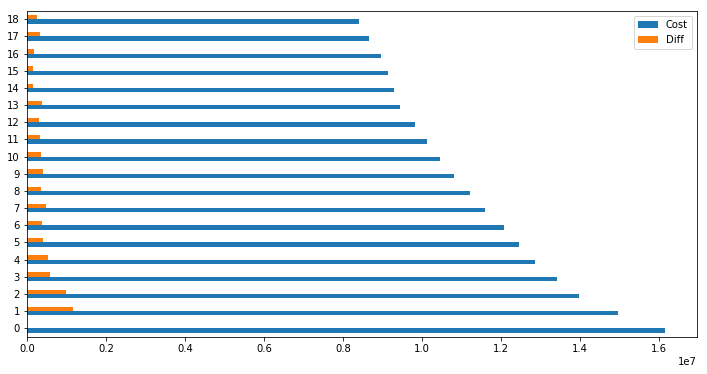

In [37]:
# acc_table.plot.line()
acc_table.plot.barh()

In [38]:
acc_table

,Clusters,Cost,Diff
0,Clusters 2,1.61402e+07,NaN
1,Clusters 3,1.49714e+07,1.16886e+06
2,Clusters 4,1.39838e+07,987580
3,Clusters 5,1.3404e+07,579824
4,Clusters 6,1.28598e+07,544128
5,Clusters 7,1.24426e+07,417285
6,Clusters 8,1.20667e+07,375833
7,Clusters 9,1.15822e+07,484517
8,Clusters 10,1.12251e+07,357123
9,Clusters 11,1.08198e+07,405314


In [39]:
# Number of clusters
kmeans = KMeans(n_clusters=15, random_state=12345)
# Fitting the input data
kmeans = kmeans.fit(principalComponents)
# Getting the cluster labels
labels = kmeans.predict(principalComponents)
# Centroid values
# centroids = kmeans.cluster_centers_

In [40]:
pd.value_counts(labels, dropna=False)

0     14930
10    13306
8      9700
11     9657
5      6700
1      6325
6      5344
7      3376
2      3059
4      2827
3      2816
12     2580
14     2388
9       901
13      393
dtype: int64

In [41]:
len(labels)

84302

In [42]:
inter = kmeans.inertia_
print("cost:", inter)

cost: 9440310.015058529


In [43]:
df["CLUSTER_NR"] = labels

In [ ]:
#df[['BAL_AVG_MG_NEW_HOUSE', 'BAL_AVG_MG_RENOVATION', 'CAT_CNT_MG']].head(20)

In [44]:
pd.value_counts(df['CAT_CNT_MG'], dropna=False)

NaN    72067
1.0    11822
2.0      413
Name: CAT_CNT_MG, dtype: int64

In [45]:
np.mean(df[['BAL_AVG_MG_NEW_HOUSE', 'BAL_AVG_MG_RENOVATION', 'CAT_CNT_MG']], )

BAL_AVG_MG_NEW_HOUSE     35380.034827
BAL_AVG_MG_RENOVATION    17677.120955
CAT_CNT_MG                   1.033756
dtype: float64

In [46]:
cols_to_aggregate = ['CLUSTER_NR',
'BAL_AVG_AL_PROMOTION',
'BAL_AVG_AL_STANDARD',
'BAL_AVG_CA_PAYROLL',
'BAL_AVG_CA_STANDARD',
'BAL_AVG_CC_MASTERCARD_GOLD',
'BAL_AVG_CC_MASTERCARD_PLATINUM',
'BAL_AVG_CC_MASTERCARD_STANDARD',
'BAL_AVG_CC_VISA_ELECTRON',
'BAL_AVG_CC_VISA_GOLD',
'BAL_AVG_CC_VISA_PLATINUM',
'BAL_AVG_MG_NEW_HOUSE',
'BAL_AVG_MG_RENOVATION',
'BAL_AVG_OVD',
'BAL_AVG_PL_F_NON_SEC',
'BAL_AVG_PL_F_SEC',
'BAL_AVG_PL_V',
'BAL_AVG_SA',
'BAL_AVG_TD_LT',
'BAL_AVG_TD_ST',
'CAT_CNT_AL',
'CAT_CNT_CA',
'CAT_CNT_CC',
'CAT_CNT_MG',
'CAT_CNT_OVD',
'CAT_CNT_PL',
'CAT_CNT_SA',
'CAT_CNT_TD',
'TNAM_CC',
'TNAM_DC',
'TNAM_LD',
'TOTAL_NUTN',
'TOTAL_TNAM',
'TNAM_CC_ATM',
'TNAM_CC_POS',
'TNAM_DC_ATM',
'TNAM_DC_POS',
'TNAM_LD_ATM',
'TNAM_LD_BRANCH',
'TNAM_LD_INTERNET',
'TNAM_LD_OTHER'
]

In [134]:
df_null = df.fillna(0)

In [48]:
aggregated = pd.pivot_table(df_null[cols_to_aggregate], columns=['CLUSTER_NR'])

In [49]:
aggregated_total = pd.DataFrame(np.mean(df_null[cols_to_aggregate]), columns=["Total"])

In [50]:
aggregated = aggregated.merge(aggregated_total, how="left", left_index=True, right_index=True)

In [51]:
aggregated.round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Total
BAL_AVG_AL_PROMOTION,0.00,0.00,0.00,0.00,0.35,0.00,0.00,0.00,0.00,626.63,0.00,0.00,-0.01,0.00,0.00,6.71
BAL_AVG_AL_STANDARD,0.00,0.17,0.18,3.86,1.43,0.05,0.00,0.01,0.10,12.34,0.08,0.00,5.65,24.57,660.90,19.36
BAL_AVG_CA_PAYROLL,140.33,819.49,914.36,915.28,861.59,728.01,1380.02,803.05,827.36,716.91,906.19,929.67,883.16,18765.84,839.94,847.17
BAL_AVG_CA_STANDARD,230.67,875.90,1064.99,1051.53,1076.82,897.52,2936.90,1000.95,967.92,986.00,877.41,2115.44,1169.36,65484.88,1058.74,1387.82
BAL_AVG_CC_MASTERCARD_GOLD,0.00,10.73,14.30,1980.21,19.25,0.84,2.00,13.32,0.00,71.26,0.29,0.00,0.00,83.89,33.20,70.98
BAL_AVG_CC_MASTERCARD_PLATINUM,0.04,7.01,10.25,0.00,5.73,0.58,2.15,6.22,0.00,86.17,0.22,0.08,3427.61,97.32,25.77,108.58
BAL_AVG_CC_MASTERCARD_STANDARD,0.00,57.82,56.18,0.00,374.17,9.21,19.32,60.61,709.19,96.70,6.16,1.94,0.22,78.94,76.78,109.69
BAL_AVG_CC_VISA_ELECTRON,0.05,86.04,89.52,348.18,0.00,21.89,37.07,86.40,762.01,124.62,16.14,4.43,578.88,139.00,110.45,142.45
BAL_AVG_CC_VISA_GOLD,0.00,24.25,33.99,90.38,2031.65,0.83,3.72,23.68,0.00,65.05,0.67,0.00,354.53,65.91,61.68,89.16
BAL_AVG_CC_VISA_PLATINUM,0.04,31.57,15.89,445.95,0.00,4.50,6.92,18.21,443.78,70.38,1.67,0.10,281.11,77.84,26.64,81.19


### Assign Flag values

In [135]:
df_null[df_null["CLUSTER_NR"].isin([4, 5, 8]) & (df_null["CAT_CNT_MG"]==0)].shape

(18394, 278)

In [166]:
mask = df_null["CLUSTER_NR"].isin([4, 5, 8]) & (df_null["CAT_CNT_MG"]==0)

In [167]:
pd.value_counts(mask)

False    65908
True     18394
dtype: int64

In [168]:
mask13 = df_null["CLUSTER_NR"].isin([13]) & (df_null["CAT_CNT_MG"]==0)

In [169]:
df_null[df_null["CLUSTER_NR"].isin([13]) & (df_null["CAT_CNT_MG"]==0)].shape

(349, 278)

In [170]:
mask_no_mg = ~df_null["CLUSTER_NR"].isin([4, 5, 8, 13]) & (df_null["CAT_CNT_MG"]!=1)

In [171]:
pd.value_counts(mask_no_mg)

True     53729
False    30573
dtype: int64

In [172]:
#prospects for MG offer
mask_mg = mask.copy()

In [176]:
# first 4800 from 4, 5, 8 clusters
mask_mg[mask_mg[mask_mg==True].iloc[4800:].index] = False

In [177]:
# first 3000 not from 4, 5, 8 clusters
mask_mg[mask_no_mg[mask_no_mg==True].iloc[:3000].index] = True

In [178]:
# firsrt 200 from cluster 13
mask_mg[mask13[mask13==True].iloc[:200].index] = True

In [179]:
pd.value_counts(mask_mg)

False    76302
True      8000
dtype: int64

In [180]:
# MG offer flag
df_null['MG_OFFER'] = 0

In [181]:
df_null['MG_OFFER'][mask_mg] = 1

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [182]:
pd.value_counts(df_null['MG_OFFER'])

0    76302
1     8000
Name: MG_OFFER, dtype: int64

In [183]:
pd.value_counts(df_null['CLUSTER_NR'][df_null['MG_OFFER']==1])

8     2439
5     1696
0      827
10     737
4      665
11     572
6      264
13     200
2      153
3      144
12     139
14      99
9       39
7       17
1        9
Name: CLUSTER_NR, dtype: int64

In [184]:
df_null[(df_null['MG_OFFER']==1) & (df_null["CAT_CNT_MG"]==1)]

,Customer_ID,AGE_MONTHS,SECTOR,CUSTOMER_ECO_BRANCH,MARITAL_STATUS,GENDER,CUSTOMER_CATEGORY,CUSTOMER_TYPE,AT_LEAST_ONE_ACTIVE,AVG_DEPOSITS_minus_LOANS,...,TOTAL_SAVING_CNT,TOTAL_TNAM,CLOSED_MONTHS_MIN,DC_MATURE_MONTHS_MAX,MATURE_MONTHS_MAX,MATURE_MONTHS_MIN,MONTHS_TILL_EXP_MAX,MONTHS_TILL_EXP_MIN,CLUSTER_NR,MG_OFFER


In [185]:
df_to_blob = df_null[['Customer_ID', 'MG_OFFER']]

In [186]:
df_to_blob.shape

(84302, 2)

In [187]:
def write_pandas_dataframe_to_blob(blob_service, df, container_name, blob_name):
    """ Write Pandas dataframe to blob storage """
    buffer = BytesIO()
    df.to_parquet(buffer)
    blob_service.create_blob_from_bytes(
        container_name=container_name, blob_name=blob_name, blob=buffer.getvalue()
    )

In [188]:
write_to_blob_parquet = 'ailiev/MG_Offer_6.parquet.gzip'

In [189]:
# Write to blob using pyarrow
write_pandas_dataframe_to_blob(blob_service, df_to_blob, 'banking-dm', write_to_blob_parquet)